# lib

In [1]:
import pickle
import warnings
warnings.filterwarnings('ignore')
import os
import pandas as pd
import numpy as np
import math
import datetime as dt
import matplotlib.pyplot as plt

from sklearn.metrics import mean_squared_error, mean_absolute_error, explained_variance_score, r2_score 
from sklearn.metrics import mean_poisson_deviance, mean_gamma_deviance, accuracy_score
from sklearn.preprocessing import MinMaxScaler , StandardScaler

from itertools import product
import statsmodels.api as sm

import tensorflow as tf

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.layers import LSTM

from itertools import cycle
import plotly.offline as py
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots

plt.style.use('seaborn-darkgrid')

# preprocessing data

In [2]:
import pandas_ta as ta

In [3]:
path_to_file = "btc.csv"

In [4]:
btc = pd.read_csv(path_to_file, skiprows=1)
btc = btc[::-1]
# btc = btc[2100:]
btc = btc.astype({'date': 'datetime64'}).set_index('date')
btc = btc.drop(['unix', 'symbol','Volume USD'], axis=1)

btc.head()

,open,high,low,close,Volume BTC
date,,,,,
2014-11-28,363.59,381.34,360.57,376.28,3220878.18
2014-11-29,376.42,386.60,372.25,376.72,2746157.05
2014-11-30,376.57,381.99,373.32,373.34,1145566.61
2014-12-01,376.40,382.31,373.03,378.39,2520662.37
2014-12-02,378.39,382.86,375.23,379.25,2593576.46


<AxesSubplot:title={'center':'Bitcoin Weighted Price'}, xlabel='date'>

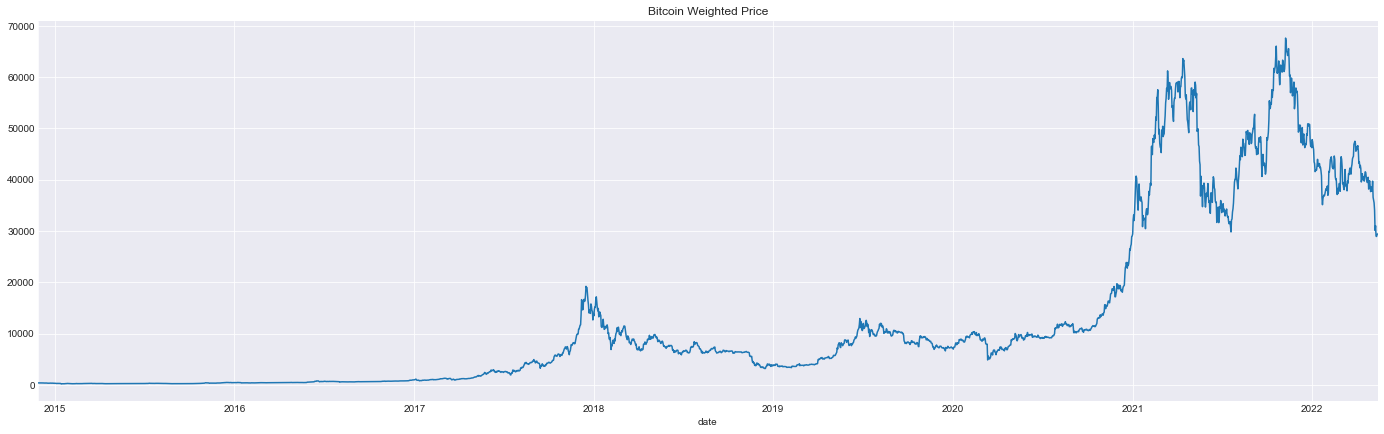

In [5]:
# btc_input_df_datetype.set_index("time").close.plot(figsize=(24,7), title="Bitcoin Weighted Price")
btc.close.plot(figsize=(24,7), title="Bitcoin Weighted Price")

In [6]:

btc['close_log'] =  np.log(btc['close'])
btc['diff1_log'] = btc['close_log'].diff()
btc['diff7_log'] = btc['close_log'].diff(7)
btc['diff30_log'] = btc['close_log'].diff(30)
btc['diff1'] = btc['close'].diff()
btc['diff7'] = btc['close'].diff(7)
btc['diff30'] = btc['close'].diff(30)
# btc['reverse_diff'] = btc['close'].shift(1) + btc['diff']
btc['rsi'] = ta.rsi(btc['close'],length=14)
btc['mom'] = ta.mom(btc['close'],length=10)
btc['target_log'] = btc['close_log'].shift(-1)
btc['target'] = btc['close'].shift(-1)
btc = btc.dropna()

In [7]:
btc.tail()

,open,high,low,close,Volume BTC,close_log,diff1_log,diff7_log,diff30_log,diff1,diff7,diff30,rsi,mom,target_log,target
date,,,,,,,,,,,,,,,,
2022-05-09,34051.20,34224.35,30015.00,30082.00,7631.121662,10.311682,-0.123183,-0.247277,-0.351861,-3943.50,-8439.01,-12685.89,24.506606,-8511.42,10.341742,30999.97
2022-05-10,30066.48,32650.00,29731.03,30999.97,7402.302313,10.341742,0.030059,-0.196468,-0.306865,917.97,-6729.98,-11133.88,28.604810,-6639.83,10.275051,29000.00
2022-05-11,31002.27,32148.15,27757.77,29000.00,11180.848836,10.275051,-0.066690,-0.313683,-0.309634,-1999.97,-10685.23,-10524.86,25.373064,-9488.34,10.271465,28896.19
2022-05-12,28999.99,30090.70,25401.05,28896.19,16578.810599,10.271465,-0.003586,-0.234532,-0.327603,-103.81,-7637.74,-11201.27,25.213830,-9624.82,10.283252,29238.81
2022-05-13,28932.69,30974.60,28686.37,29238.81,6010.273639,10.283252,0.011787,-0.208556,-0.341672,342.62,-6780.41,-11908.93,26.845615,-8491.14,10.288993,29407.14


In [8]:
scaler = MinMaxScaler(feature_range=(0, 1))
scaler_t = MinMaxScaler(feature_range=(0, 1))
scaler_tlog = MinMaxScaler(feature_range=(0, 1))
# # StandardScaler
# scaler = StandardScaler()
# scaler_t = StandardScaler()
# scaler_tlog = StandardScaler()


btc.diff1_log = scaler.fit_transform(btc.diff1_log.values.reshape(-1,1))
btc.diff7_log = scaler.fit_transform(btc.diff7_log.values.reshape(-1,1))
btc.diff30_log = scaler.fit_transform(btc.diff30_log.values.reshape(-1,1))
btc.diff1 = scaler.fit_transform(btc.diff1.values.reshape(-1,1))
btc.diff7 = scaler.fit_transform(btc.diff7.values.reshape(-1,1))
btc.diff30 = scaler.fit_transform(btc.diff30.values.reshape(-1,1))
btc.rsi = scaler.fit_transform(btc.rsi.values.reshape(-1,1))
btc.mom = scaler.fit_transform(btc.mom.values.reshape(-1,1))

btc.close = scaler_t.fit_transform(btc.close.values.reshape(-1,1))
btc.target = scaler_t.transform(btc.target.values.reshape(-1,1))

btc.close_log = scaler_tlog.fit_transform(btc.close_log.values.reshape(-1,1))
btc.target_log = scaler_tlog.transform(btc.target_log.values.reshape(-1,1))


In [9]:
prediction_days = 60

df_train_= btc[:][:len(btc)-prediction_days]#values.reshape(-1,1)

df_test_= btc[:][len(btc)-prediction_days:]#.values.reshape(-1,1)

# creat data lstm

In [10]:
df_train_.columns

Index(['open', 'high', 'low', 'close', 'Volume BTC', 'close_log', 'diff1_log',
       'diff7_log', 'diff30_log', 'diff1', 'diff7', 'diff30', 'rsi', 'mom',
       'target_log', 'target'],
      dtype='object')

In [11]:
df_train = df_train_[:][['close_log', 'target_log']]
df_test = df_test_[:][['close_log', 'target_log']]
df_test.head(2)

,close_log,target_log
date,,
2022-03-15,0.910212,0.917795
2022-03-16,0.917795,0.917071


In [12]:
# many to one

look_back_ = 5

from collections import deque
def dataset_generator_lstm(dataset, look_back=look_back_):
  sequential_data = [] 
  prev_days = deque(maxlen=look_back)
  for i in dataset.values:
    prev_days.append([n for n in i[:-1]])
    if len(prev_days) == look_back:  
      sequential_data.append([np.array(prev_days), i[-1]])
  dataX=[]
  dataY=[]
  for seq, target in sequential_data: 
    dataX.append(seq) 
    dataY.append(target) 
  return np.array(dataX), np.array(dataY)

trainX, trainY = dataset_generator_lstm(df_train)
trainX, trainY = trainX[2100:], trainY[2100:]
testX, testY = dataset_generator_lstm(df_test)

print("trainX: ", trainX.shape)
print("trainY: ", trainY.shape)
print("testY: ", testX.shape)
print("testY", testY.shape)

trainX:  (530, 5, 1)
trainY:  (530,)
testY:  (56, 5, 1)
testY (56,)


# train

In [13]:
regressor = Sequential()

regressor.add(LSTM(units = 256, activation = 'relu',return_sequences=True, input_shape = (trainX.shape[1], trainX.shape[2])))
regressor.add(Dropout(0.2))
# 

regressor.add(LSTM(units = 128, activation = 'relu', input_shape = (trainX.shape[1], trainX.shape[2])))
# regressor.add(LSTM(units = 64, return_sequences = True, input_shape = (trainX.shape[1], trainX.shape[2])))

regressor.add(Dropout(0.2))


regressor.add(Dense(units = 1))

regressor.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 5, 256)            264192    
                                                                 
 dropout (Dropout)           (None, 5, 256)            0         
                                                                 
 lstm_1 (LSTM)               (None, 128)               197120    
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense (Dense)               (None, 1)                 129       
                                                                 
Total params: 461,441
Trainable params: 461,441
Non-trainable params: 0
_________________________________________________________________


In [14]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping


regressor.compile(optimizer = 'adam', loss = 'mean_squared_error')

checkpoint_path = 'my_best_model.hdf5'

checkpoint = ModelCheckpoint(filepath=checkpoint_path, 
                             monitor='loss',
                             verbose=1, 
                             save_best_only=True,
                             mode='min')


earlystopping = EarlyStopping(monitor='loss', patience=10, restore_best_weights=True)

callbacks = [checkpoint, earlystopping]


# history = regressor.fit(trainX[(len(trainY)-370):], trainY[(len(trainY)-370):], batch_size = 128, epochs = 300, verbose=1, shuffle=False, validation_data=(testX, testY), callbacks=callbacks)
history = regressor.fit(trainX, trainY, batch_size = 128, epochs = 300, verbose=1, shuffle=False, validation_data=(testX, testY), callbacks=callbacks)

Epoch 1/300
3/5 [=================>............] - ETA: 0s - loss: 0.7377
Epoch 1: loss improved from inf to 0.72389, saving model to my_best_model.hdf5
5/5 [==============================] - 2s 102ms/step - loss: 0.7239 - val_loss: 0.5224
Epoch 2/300
3/5 [=================>............] - ETA: 0s - loss: 0.4272
Epoch 2: loss improved from 0.72389 to 0.39548, saving model to my_best_model.hdf5
5/5 [==============================] - 0s 36ms/step - loss: 0.3955 - val_loss: 0.1322
Epoch 3/300
3/5 [=================>............] - ETA: 0s - loss: 0.0622
Epoch 3: loss improved from 0.39548 to 0.05005, saving model to my_best_model.hdf5
5/5 [==============================] - 0s 35ms/step - loss: 0.0501 - val_loss: 0.1062
Epoch 4/300
4/5 [=======================>......] - ETA: 0s - loss: 0.0885
Epoch 4: loss did not improve from 0.05005
5/5 [==============================] - 0s 25ms/step - loss: 0.0864 - val_loss: 0.0013
Epoch 5/300
4/5 [=======================>......] - ETA: 0s - loss: 0.01

Epoch 38/300
4/5 [=======================>......] - ETA: 0s - loss: 0.0045
Epoch 38: loss did not improve from 0.00438
5/5 [==============================] - 0s 25ms/step - loss: 0.0044 - val_loss: 3.4742e-04
Epoch 39/300
4/5 [=======================>......] - ETA: 0s - loss: 0.0050
Epoch 39: loss did not improve from 0.00438
5/5 [==============================] - 0s 27ms/step - loss: 0.0049 - val_loss: 1.2680e-04
Epoch 40/300
3/5 [=================>............] - ETA: 0s - loss: 0.0051
Epoch 40: loss did not improve from 0.00438
5/5 [==============================] - 0s 27ms/step - loss: 0.0052 - val_loss: 1.2467e-04
Epoch 41/300
4/5 [=======================>......] - ETA: 0s - loss: 0.0050
Epoch 41: loss did not improve from 0.00438
5/5 [==============================] - 0s 25ms/step - loss: 0.0050 - val_loss: 1.1997e-04
Epoch 42/300
3/5 [=================>............] - ETA: 0s - loss: 0.0052
Epoch 42: loss did not improve from 0.00438
5/5 [==============================] - 0s 27m

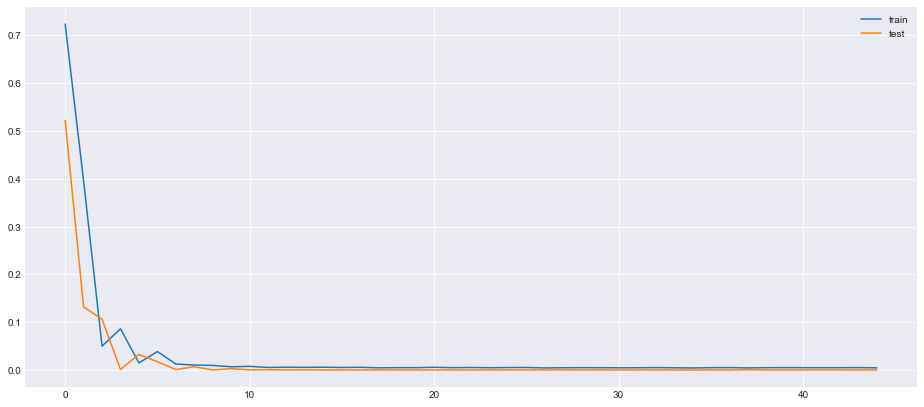

In [15]:
plt.figure(figsize=(16,7))
plt.plot(history.history['loss'], label='train')

plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

In [16]:
from tensorflow.keras.models import load_model

model_from_saved_checkpoint = load_model('my_best_model.hdf5')

# test test

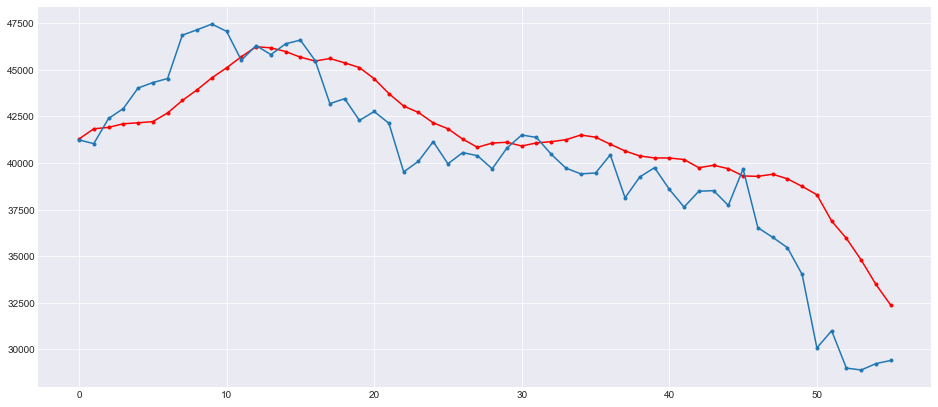

In [17]:
plt.figure(figsize=(16,7))

# log
predicted_btc_price_test_data = model_from_saved_checkpoint.predict(testX)
predicted_btc_price_test_data = scaler_tlog.inverse_transform(predicted_btc_price_test_data.reshape(-1, 1))
test_actual = scaler_tlog.inverse_transform(testY.reshape(-1, 1))

plt.plot(np.exp(predicted_btc_price_test_data), 'r', marker='.', label='Predicted Test')
plt.plot(np.exp(test_actual), marker='.', label='Actual Test')

# # manoal
# predicted_btc_price_test_data = model_from_saved_checkpoint.predict(testX)
# predicted_btc_price_test_data = scaler_t.inverse_transform(predicted_btc_price_test_data.reshape(-1, 1))
# test_actual = scaler_t.inverse_transform(testY.reshape(-1, 1))

# plt.plot(predicted_btc_price_test_data, 'r', marker='.', label='Predicted Test')
# plt.plot(test_actual, marker='.', label='Actual Test')
# plt.legend()
# plt.show()

# test train

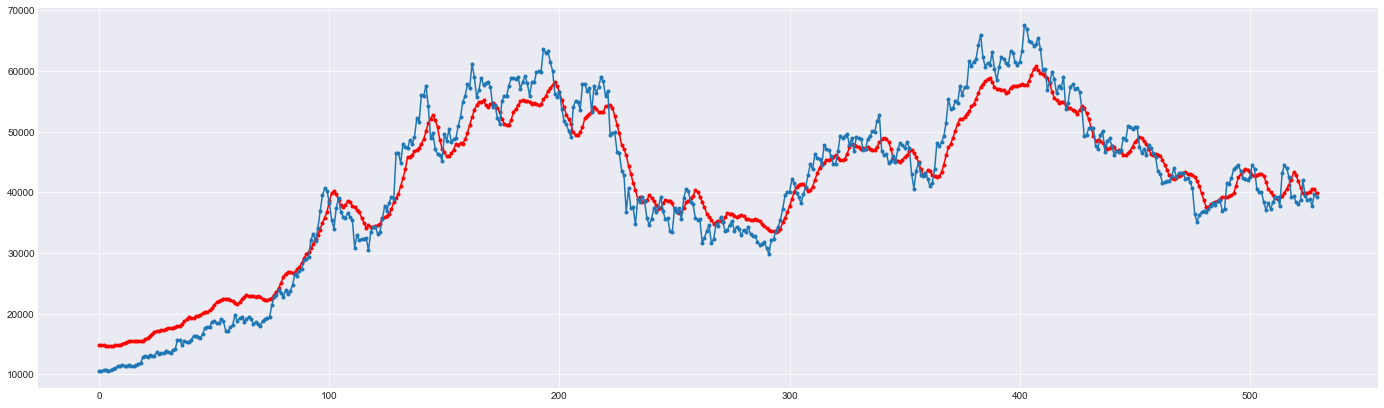

In [18]:
plt.figure(figsize=(24,7))

# log
predicted_btc_price_train_data = model_from_saved_checkpoint.predict(trainX)
predicted_btc_price_train_data = scaler_tlog.inverse_transform(predicted_btc_price_train_data.reshape(-1, 1))
train_actual = scaler_tlog.inverse_transform(trainY.reshape(-1, 1))

plt.plot(np.exp(predicted_btc_price_train_data), 'r', marker='.', label='Predicted Test')
plt.plot(np.exp(train_actual), marker='.', label='Actual Test')

# # manoal
# predicted_btc_price_train_data = model_from_saved_checkpoint.predict(trainX)
# predicted_btc_price_train_data = scaler_t.inverse_transform(predicted_btc_price_train_data.reshape(-1, 1))
# train_actual = scaler_t.inverse_transform(trainY.reshape(-1, 1))

# plt.plot(predicted_btc_price_train_data, 'r', marker='.', label='Predicted Test')
# plt.plot(train_actual, marker='.', label='Actual Test')
# plt.legend()
# plt.show()

# future

###### many to one

In [19]:
from collections import deque
SEQ_LEN=len(testX[-1])
prev_days = deque(maxlen=SEQ_LEN)

for i in range(-len(testX[-1]),0,1):
  # prev_days.append(scaler.transform(test_actual[i].reshape(-1,1)))
  prev_days.append(testX[-1][i])

In [20]:
y_p_ = []
future_len = 180
for i in range(future_len):
  x__ = np.array(prev_days).reshape(-1,1).astype(np.float32)

  per = model_from_saved_checkpoint.predict(np.array([x__,x__]))[0].reshape(-1,1)
  prev_days.append(per.reshape(-1,1))
  y_p_.append(per.reshape(-1,1))
  # y_p_.append(scaler.inverse_transform(per.reshape(-1,1)))


In [21]:
# log
y_p_ = scaler_tlog.inverse_transform(np.array(y_p_).reshape(-1, 1))
# manoal
# y_p_ = scaler_t.inverse_transform(np.array(y_p_).reshape(-1, 1))

###### plot future

In [22]:
actual = np.concatenate((train_actual,test_actual))
predicted_btc_price = np.concatenate((predicted_btc_price_train_data, predicted_btc_price_test_data, np.array(y_p_).reshape(-1,1)), axis=0)

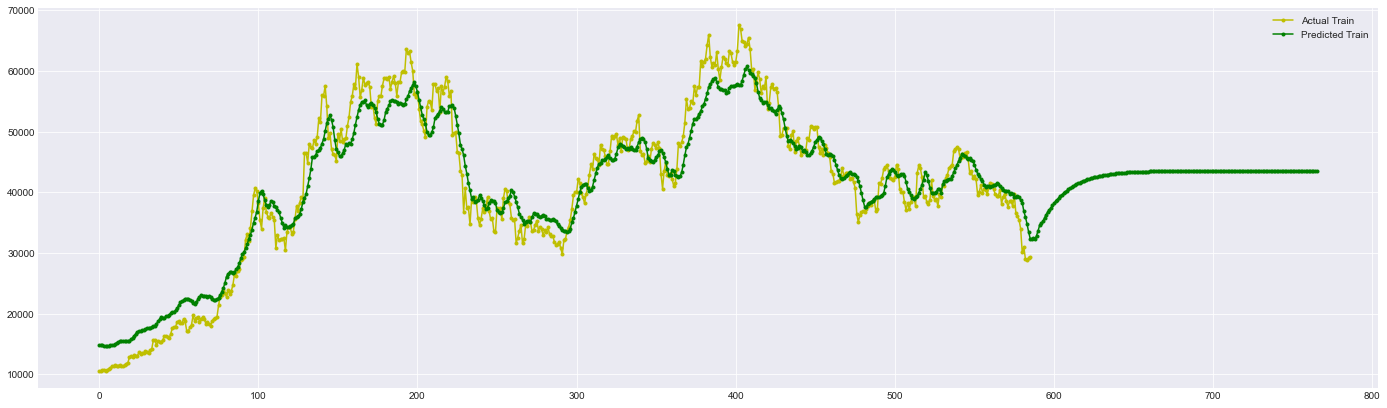

In [23]:
plt.figure(figsize=(24,7))

# log
plt.plot(np.exp(actual),'y', marker='.', label='Actual Train')
plt.plot(np.exp(predicted_btc_price), 'g', marker='.', label='Predicted Train')
# manoal
# plt.plot(actual,'y', marker='.', label='Actual Train')
# plt.plot(predicted_btc_price, 'g', marker='.', label='Predicted Train')


plt.legend()
plt.show()